# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

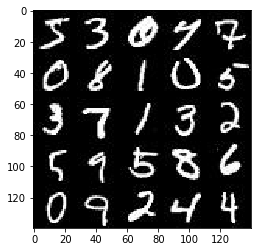

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

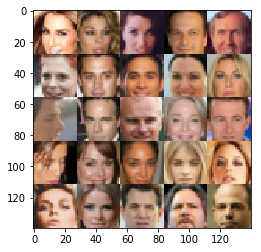

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\eg

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
             filters = filters, 
             kernel_size = 5, 
             strides = 1,
             padding="same")
        x = tf.concat([images,tf.contrib.keras.layers.LeakyReLU(alpha)(x)],3)
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    init_dim =[-1,7,7,512]
    init_len = 7*7*512
    filters = 512
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')

            x = tf.layers.batch_normalization(x, training = is_train)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 5,
                                   strides = 1,
                                   padding = 'same')
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:2*learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0439... Generator Loss: 3.8472
Epoch 1/2... Discriminator Loss: 0.0578... Generator Loss: 3.2687
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 9.0562
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.5611
Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 2.6375
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 1.1641
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 1.0249
Epoch 1/2... Discriminator Loss: 1.9153... Generator Loss: 0.3056
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.1526


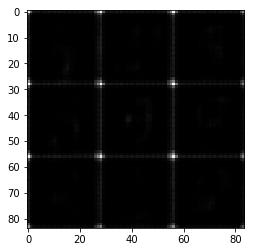

Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 1.4710
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.5533
Epoch 1/2... Discriminator Loss: 1.5753... Generator Loss: 0.3274
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.1277


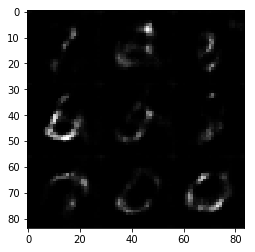

Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.4158
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.6104
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.3490
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.3948
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.3483


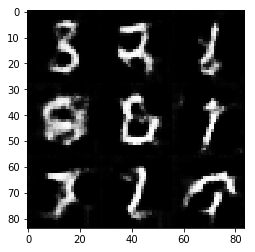

Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.3390
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.0518... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.6789
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 0.9358


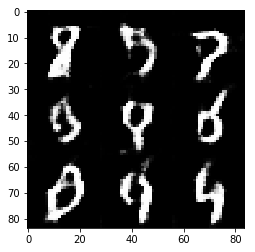

Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7005


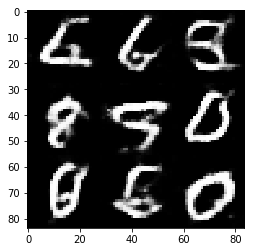

Epoch 1/2... Discriminator Loss: 1.8929... Generator Loss: 0.2549
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 2.9839
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.4240
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.1295


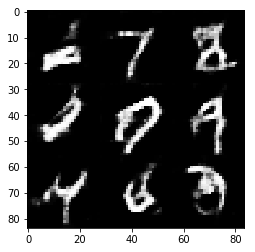

Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 2.2557... Generator Loss: 0.2049
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.5381
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 0.7438


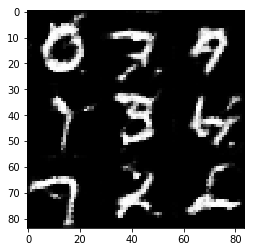

Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 0.9577
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 0.5655... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.4101
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 0.7444
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 0.9441


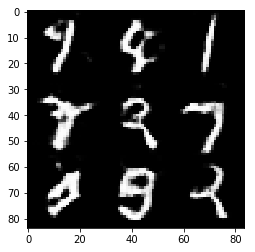

Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 1.5981
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 1.2740
Epoch 1/2... Discriminator Loss: 2.4033... Generator Loss: 0.1697
Epoch 1/2... Discriminator Loss: 2.9443... Generator Loss: 0.0958
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.1551
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 1.0957


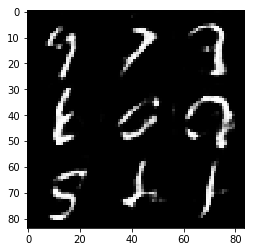

Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 0.7986... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.0969
Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 1.7163
Epoch 2/2... Discriminator Loss: 0.6814... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.3977
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.7082
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.5162


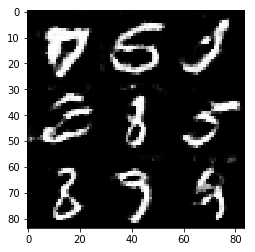

Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 0.5875... Generator Loss: 1.3493
Epoch 2/2... Discriminator Loss: 0.5138... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 2.4643... Generator Loss: 3.7363
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.5730
Epoch 2/2... Discriminator Loss: 0.3332... Generator Loss: 2.4890
Epoch 2/2... Discriminator Loss: 1.8560... Generator Loss: 0.2352
Epoch 2/2... Discriminator Loss: 0.5103... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 1.0036


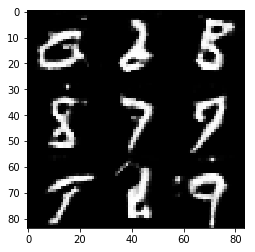

Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 1.9134
Epoch 2/2... Discriminator Loss: 0.4282... Generator Loss: 1.9470
Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 0.9320
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 0.4306... Generator Loss: 1.4708
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 2.3229
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 2.4612
Epoch 2/2... Discriminator Loss: 0.7574... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 0.8201


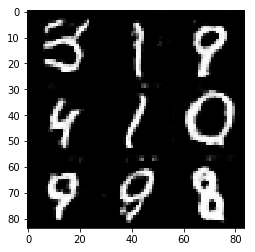

Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 1.4234
Epoch 2/2... Discriminator Loss: 0.3645... Generator Loss: 1.6598
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 2.2548
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 2.3307
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 2.7127
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 0.4690... Generator Loss: 2.5311
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 1.6708


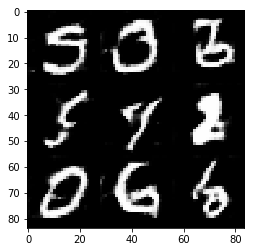

Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 1.3528
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 2.6192
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 1.6040
Epoch 2/2... Discriminator Loss: 2.1964... Generator Loss: 0.1983
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 3.5900
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.3704... Generator Loss: 2.3340
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 3.0451


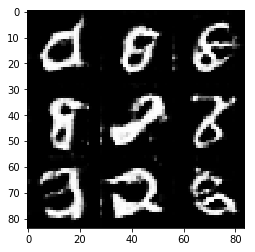

Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 1.9239
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 1.2984
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 1.3757
Epoch 2/2... Discriminator Loss: 0.2788... Generator Loss: 2.4878
Epoch 2/2... Discriminator Loss: 2.5514... Generator Loss: 0.1116
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 1.8726
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 1.3614


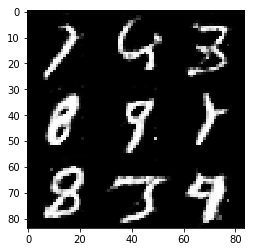

Epoch 2/2... Discriminator Loss: 0.2931... Generator Loss: 1.9403
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 1.7456
Epoch 2/2... Discriminator Loss: 0.2878... Generator Loss: 1.9103
Epoch 2/2... Discriminator Loss: 0.2921... Generator Loss: 1.9496
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 1.3058
Epoch 2/2... Discriminator Loss: 1.6706... Generator Loss: 0.3838
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.4425
Epoch 2/2... Discriminator Loss: 0.4577... Generator Loss: 1.4189
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 3.3316
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 2.5913


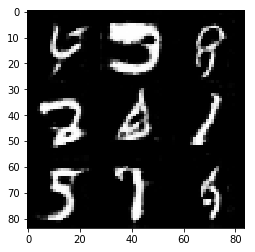

Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 1.8377
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 0.9152
Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 1.4658
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 2.9220... Generator Loss: 0.1117
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 2.4577
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 0.4177... Generator Loss: 1.4463


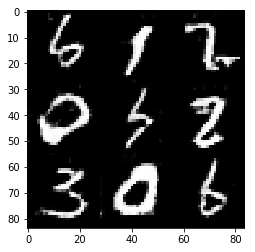

Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.6443... Generator Loss: 0.2904
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.7190
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 2.5486
Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 2.0848
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.6613
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.0847


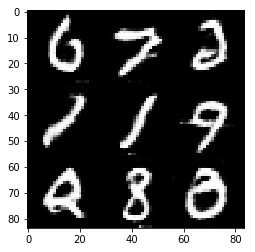

Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.9324
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 1.2723
Epoch 2/2... Discriminator Loss: 0.5301... Generator Loss: 1.9956
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.8987


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1332... Generator Loss: 0.1028
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.6597
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 3.4429


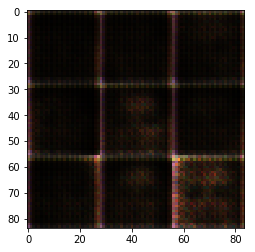

Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 4.2222
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 3.8738
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.5047


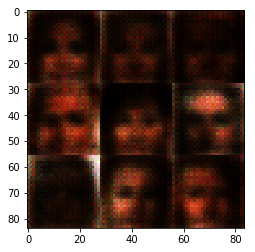

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.3950
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 2.2722
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 3.1429
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.0297


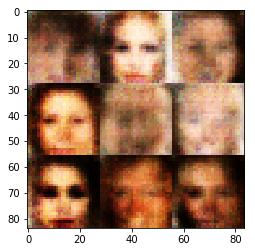

Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8329


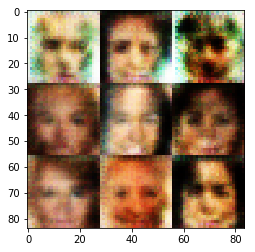

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.5570
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 2.0359... Generator Loss: 0.1960
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.8078... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8655


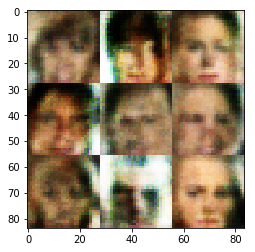

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 2.4177... Generator Loss: 1.6341
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.7724... Generator Loss: 2.2225
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 2.0290
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 2.1134
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.3539


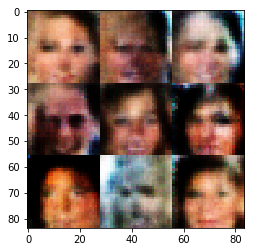

Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 2.8881
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 1.7999
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 3.4002
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.3230
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.3682


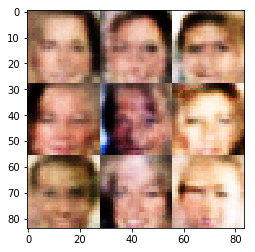

Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 1.9223... Generator Loss: 0.1937
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 3.0878
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 2.6142
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 1.9397... Generator Loss: 0.2082
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 2.1533
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 3.3703


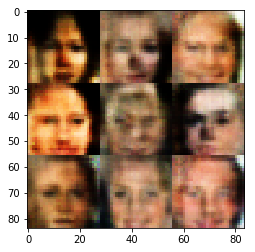

Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.3080... Generator Loss: 3.7041
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 4.0877
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 0.2203... Generator Loss: 5.0172


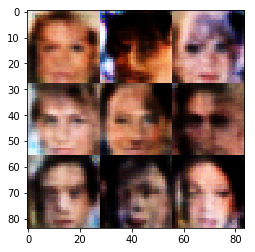

Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.7065... Generator Loss: 4.0127
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 2.2478
Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 2.8634
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 2.5255
Epoch 1/1... Discriminator Loss: 0.2777... Generator Loss: 2.8389
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 3.4516


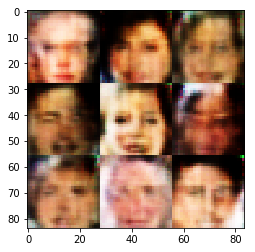

Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 3.2318
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.2428
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 2.1248
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 3.0124
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 2.7293
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.0413
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.5905


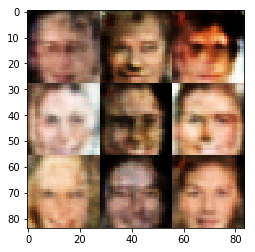

Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.3458
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 3.4887
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 4.7121
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 2.2125
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.6684
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 2.3593
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 1.9459
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 1.8189


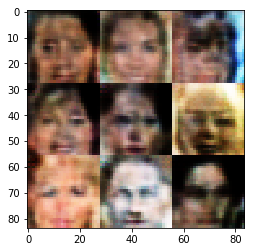

Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 3.8796... Generator Loss: 3.0967
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.9455


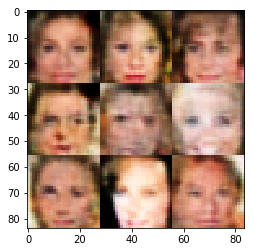

Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 1.6575
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 2.8165
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 5.5278
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 2.3408
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 2.8893
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.0666


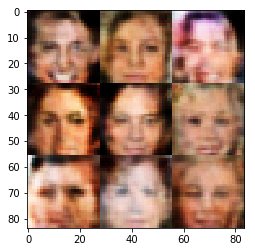

Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 2.6135
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 2.7533... Generator Loss: 1.9727
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.0243
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.1676


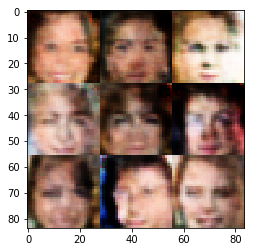

Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.7565
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 2.1010... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 0.2854... Generator Loss: 6.9589
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 1.9342


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.